# AQI Forecasting with Prophet
This notebook forecasts daily AQI for Delhi using Prophet. Steps: (1) load data, (2) clean missing values, (3) fit Prophet with cmdstanpy backend, (4) forecast 12 months ahead, (5) evaluate with cross-validation, (6) visualize forecast bands.

In [1]:
# Importing required libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## 1. Load core libraries
Import plotting, data, and visualization libraries; suppress warnings for a clean run.

In [2]:
#Reading the data
df_city = pd.read_csv("./datasets/city_day.csv")

In [7]:
print(df_city.info())
df_city.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         29503 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB
None


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


## 2. Inspect data quality
Quickly check missingness and decide how to fill gaps before modeling.

<Axes: >

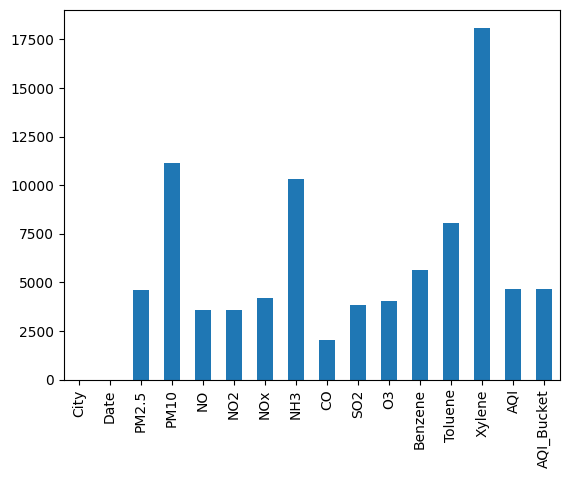

In [4]:
df_city.isnull().sum().plot(kind ='bar')

In [5]:
df_city['AQI'] = df_city['AQI'].ffill()
#df_city['AQI'] = df_city['AQI'].bfill()
#df_city['AQI'].fillna(value = 0,inplace = True)

## 3. Prepare Prophet workflow
Set up dependencies and shape the Delhi AQI series for Prophet (ds, y).

In [9]:
%pip install cmdstanpy -q

Note: you may need to restart the kernel to use updated packages.


### 3.1 Install cmdstanpy backend
Prophet (prophet>=1.1) relies on a working stan backend; cmdstanpy keeps installs lighter than pystan.

In [10]:
from prophet import Prophet

delhi = df_city[df_city['City'] == 'Delhi']
delhi_aqi = delhi[['Date','AQI']]
delhi_aqi.reset_index(inplace = True,drop = True)

#Defining our training dataset
train_df = delhi_aqi
train_df.rename(mapper = {'Date':'ds','AQI':'y'},axis =1,inplace = True)
train_df

,ds,y
0,2015-01-01,472.0
1,2015-01-02,454.0
2,2015-01-03,143.0
3,2015-01-04,319.0
4,2015-01-05,325.0
...,...,...
2004,2020-06-27,112.0
2005,2020-06-28,196.0
2006,2020-06-29,233.0
2007,2020-06-30,114.0


### 3.2 Prepare Delhi AQI training frame
Filter Delhi rows, keep Date/AQI, and rename to Prophet-friendly columns ds/y.

In [11]:
import sys
from io import StringIO
from contextlib import contextmanager

@contextmanager
def suppress_stdout_stderr():
    """A context manager that suppresses stdout and stderr."""
    save_stdout = sys.stdout
    save_stderr = sys.stderr
    sys.stdout = StringIO()
    sys.stderr = StringIO()
    try:
        yield
    finally:
        sys.stdout = save_stdout
        sys.stderr = save_stderr

### 3.3 Silence verbose stan output
Utility context manager to keep training cells clean in the notebook UI.

In [12]:
#Train the Prophet model
model = Prophet(interval_width=0.95, yearly_seasonality=True)
with suppress_stdout_stderr():
    model.fit(train_df)

22:06:52 - cmdstanpy - INFO - Chain [1] start processing
22:06:52 - cmdstanpy - INFO - Chain [1] done processing
22:06:52 - cmdstanpy - INFO - Chain [1] done processing


## 4. Train Prophet model
Fit with yearly seasonality and 95% intervals; training runs quietly via the helper.

In [13]:
#Extrapolating the dates into future 
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
2369,2021-06-27
2370,2021-06-28
2371,2021-06-29
2372,2021-06-30
2373,2021-07-01


## 5. Forecast future dates
Extend the timeline by 365 days and generate predictions with upper/lower bands.

In [14]:
#Forecasting the AQI values
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2369,2021-06-27,11.924449,-122.714678,145.874517
2370,2021-06-28,5.343730,-129.756273,138.635682
2371,2021-06-29,4.458259,-143.323803,146.169544
2372,2021-06-30,5.330503,-129.900162,134.810459
2373,2021-07-01,5.095116,-128.958573,141.789578


### 5.1 Inspect forecast table
Peak/trough bounds are available via yhat_lower/yhat_upper.

In [15]:
#Calculating the cross validation accuracy
from prophet.diagnostics import cross_validation, performance_metrics
with suppress_stdout_stderr():
    df_cv = cross_validation(model, initial='1100 days', period='121 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
print('Cross Validation MAPE:', df_p['mape'].mean())

  0%|          | 0/8 [00:00<?, ?it/s]

22:07:17 - cmdstanpy - INFO - Chain [1] start processing
22:07:17 - cmdstanpy - INFO - Chain [1] done processing
22:07:17 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] done processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:19 - cmdstanpy - INFO - Chain [1]

Cross Validation MAPE: 0.24907055289422433


## 6. Cross-validate forecast quality
Use rolling-origin cross-validation with a 30-day horizon; report MAPE for quick accuracy read.

In [16]:
#Plotting out the forecast
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', name='upper', line=dict(width=0)))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', name='lower', line=dict(width=0)))
fig.update_layout(title='Prophet Forecast for AQI', xaxis_title='Date', yaxis_title='AQI')
fig.show()

## 7. Visualize forecast with uncertainty
Interactive Plotly chart shows median forecast and 95% credible interval.

### Notes
- AQI dips in 2020 are captured in the forecast bands.
- Cross-validation MAPE gives a quick sense of reliability; widen horizons for deeper checks.
- Adjust seasonality_prior_scale/holidays if you add event effects (e.g., lockdown periods).